
# 7-6，DeepCross模型

谷歌在CTR预估和推荐排序模型方面有3篇相对重要的文章。

第1篇是2016年的Deep&Wide,第2篇是2017年的Deep&Cross(DCN),第3篇是2020年的DCN-V2.

这3篇文章的核心思想分别用1句话概括如下：

第1篇Deep&Wide说，线性回归LR具有好的记忆能力(Wide部分),多层感知机DNN具有好的泛化能力(Deep部分),把它们并行的结合起来食用口感真香.

第2篇Deep&Cross说，将Deep&Wide的Wide部分换成一个CrossNet，可以自动捕获多层级特征交叉，减少人工特征工程。新的模型叫做DCN口感更香！

第3篇DCNV2说，DCN的CrossNet的仅仅用一个向量来建模交叉能力, 拟合能力太弱, 配方升级换成矩阵吧。升级后的DCNV2量大管饱，又香又饱！什么，矩阵太大跑的慢，不太好消化? 别急，我们还有秘制配方，把矩阵换成两个低秩矩阵的乘积，这个用了秘制配方的模型叫做DCN-Mix，嘎嘣脆，又香又饱还好消化，你值得拥有！

今天我们就来尝尝DCN、DCNV2以及嘎嘣脆的DCN-Mix！

参考文档：

* Deep&Wide论文： https://arxiv.org/pdf/1606.07792v1.pdf

* DCN论文：https://arxiv.org/pdf/1708.05123.pdf 

* DCNV2论文： https://arxiv.org/pdf/2008.13535.pdf

* 解密Deep&Cross: https://zhuanlan.zhihu.com/p/55234968 

* 大规模排序系统中的特征交叉DCN-V2: https://zhuanlan.zhihu.com/p/353223660

* 代码实现参考：https://github.com/shenweichen/DeepCTR-Torch/blob/bc881dcd417fec64f840b0cacce124bc86b3687c/deepctr_torch/layers/interaction.py#L406-L537




<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


## 一，DeepCross原理解析

谷歌的DeepCross系列模型(DCN-vector, DCN-matrix, DCN-mix) 围绕解决的核心问题三高问题。

如何实现 高效率，高表达能力 的 高阶显式特征交叉？

这三高问题分别是什么含义呢？

1，高阶：至少支持三阶特征交叉。实践证明，在CTR和推荐领域，二阶特征交叉和三阶特征交叉是有用的，四阶及以上的特征交叉没啥用。FM只是二阶显式特征交叉。 

2，高效率：特征交叉模块的预测效率最好是O(n),其中n为特征数量。

3，高表达能力：特征交叉模块有足够大的参数容量来捕获各种可能的特征交叉。

下面我们分别看看 DCN-vector， DCN-matrix, DCN-mix在三高问题的解决思路和解决程度。



### 1， DCN-vector 

DCN-vector 也就是 2017年发布的最初版本的DCN， 很好地解决了三高问题中的两高。

1，高阶 (DCN-vector可以很方便地支持三阶及以上的显式特征交叉)

2，高效率 (DCN-vector特征交叉模块的推理复杂度是O(n)，非常高效，和FM不分伯仲)

我们来看看DCN-vector怎么做的显式特征交叉。

先看图和公式。

有两个要点，一个是用和x0等长的参数向量来捕获交叉关系，第二个是参照了残差模块的设计将低阶量加回到输出中。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wduan1hmj20a30570sv.jpg)

代码和图一样好懂。

In [2]:
import torch 
from torch import nn 
class CrossNetVector(nn.Module):
    def __init__(self, d_in, n_cross=2):
        super().__init__()
        self.n_cross = n_cross
        self.linears = nn.ModuleList([nn.Linear(d_in,1,bias=False) for i in range(self.n_cross)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.zeros(d_in)) for i in range(self.n_cross)])
        
    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            xi = x0*self.linears[i](xi)+self.biases[i]+xi
        return xi

CrossNetVector的结构非常简洁。每升高一阶特征交叉，主要运算是将上一阶特征向量xi和交叉模块参数向量w做点积，并数乘原始特征向量x0。

该计算的计算前后向量的维度不变，计算量和特征向量的长度n成正比，所以复杂度是O(n).

值得注意的是，虽然CrossNetVector的复杂度很低仅仅是O(n),  但是 $x_{0}*x^{'}*\omega$ 这一项展开后是包括任意两个特征的交叉乘积贡献的。

我们知道任意两个特征的交叉共有 n(n-1)/2 种组合方式，这个复杂度是O(n^2)的，那么为什么 CrossNetVector 能够以 O(n)的复杂度实现包括O(n^2)量级的特征交叉组合贡献的呢？

原因是CrossNetVector这种结构实际上具有权重共享的特性。

假设有5个特征 x1,x2,x3,x4,x5, 如果要独立地描述它们之间的两两交叉要10个参数，但是CrossNetVector中仅仅有5个表述特征交叉系数的参数 w1,w2,w3,w4,w5

其中 x1x2的交叉项的系数是 (w1+w2), x1x3的交叉项系数时 (w1+w3),...,x1x5的交叉项系数是 (w1+w5), 可见，w1这个参数被用在了 x1和任何参数的交叉项中作为组成部分。

这就是一种权重共享的特性，这种特性有助于DCN变得轻便高效，并像FM那样学习到稀疏特征的交叉。



### 2, DCN-matrix 

DCN-vector 虽然解决了三高中的两高: 高阶、高效率。

但是它在另一高也就是高表达能力方面有些缺陷，它仅仅用一个和输入特征等长的向量来刻画特征之间的相互作用，不足以表述丰富的特征交叉模式。

CrossNetVector的参数数量相比Deep部分的MLP的参数数量来看实在微不足道，可能存在记忆容量瓶颈。

换言之，它的权值共享可能做的有些过头了。

正是基于这样的洞察，DCN-matrix 在DCN-vector基础上做了一些轻微的改动，用矩阵代替了向量，并适配性地修改了一些运算符，强化了显式特征交叉项的表达能力。


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wgsq1zcyj208u0473yj.jpg) 

代码比图更加好懂。

In [3]:
import torch 
from torch import nn 
class CrossNetMatrix(nn.Module):
    def __init__(self, d_in, n_cross=2):
        super().__init__()
        self.n_cross = n_cross
        self.linears = nn.ModuleList([nn.Linear(d_in,d_in) for i in range(self.n_cross)])
        
    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            xi = x0*self.linears[i](xi)+xi
        return xi

可以看到 CrossNetMatrix 用一个 $n\times n$ 的交互矩阵$W$来刻画 特征之间的交互，实际上$W$的第i行第j列的元素 $W_{ij}$

表达的就是第i个特征和第j个特征之间的交互项系数。 因此 CrossNetMatrix 的复杂度是O(n^2)的，并且具有很好的解释型。

于是 CrossNetMatrix整体来说是牺牲了 高效性，换来了高表达能力。不过，在许多特征数量不算特别多的情况下，例如n在1000以下的时候，CrossNetMatrix依旧是非常高效的。




### 3, DCN-mix 

DCN-mix可以说是 DCN-matrix基础上提升计算效率，同时保持高表达能力的一种方案。 

其主要思想洞察如下。

1，矩阵分解：根据SVD主成分分析理论，庞大的交互矩阵W可以由为两个低秩矩阵U和V的乘积来近似。这样可以将参数量和计算复杂度降低到O(n)。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wid7h72rj209s01ga9v.jpg)

2，专家融合：使用两个低秩矩阵U和V的乘积来近似W提升了效率但是降低了表达能力，可以使用MOE思想(Mixture of Experts)融合多个低秩空间的专家网络来提升表达能力。
![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wibupquej20eb0ayjrt.jpg)

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wiet82zxj209302ma9y.jpg)

3，低秩变换：可以在U和V之间在低秩空间上做一些变换适当再拉一拉表达能力。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h2wifm6877j20ac01d744.jpg)


整体来说，DCN-mix用到的这3个技巧还是有些难度的，可以结合代码理解一下。

In [4]:
import torch 
from torch import nn 
class CrossNetMix(nn.Module):
    def __init__(self, d_in, n_cross =2, low_rank=32, n_experts=4):
        super().__init__()
        self.d_in = d_in
        self.n_cross = n_cross
        self.low_rank = low_rank
        self.n_experts = n_experts

        # U: (d_in, low_rank)
        self.U_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, d_in, low_rank))) for i in range(self.n_cross)])

        # V: (d_in, low_rank)
        self.V_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, d_in, low_rank))) for i in range(self.n_cross)])

        # C: (low_rank, low_rank)
        self.C_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, low_rank, low_rank))) for i in range(self.n_cross)])

        # G: (d_in, 1)
        self.gating = nn.ModuleList([nn.Linear(d_in, 1, bias=False) for i in range(self.n_experts)])

        # Bias 
        self.biases = nn.ParameterList([nn.Parameter(torch.zeros(d_in)) for i in range(self.n_cross)])


    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            output_of_experts = []
            gating_score_of_experts = []
            for expert_id in range(self.n_experts):

                # (1) G(xi)
                # compute the gating score by xi
                gating_score_of_experts.append(self.gating[expert_id](xi))

                # (2) E(xi)
                # project the input xi to low_rank space
                v_x = xi@(self.V_list[i][expert_id])   # (batch_size, low_rank)

                # nonlinear activation in low rank space
                v_x = torch.tanh(v_x)
                v_x = v_x@self.C_list[i][expert_id]     # (batch_size, low_rank)
                v_x = torch.tanh(v_x)

                # project back to d_in space
                uv_x = v_x@(self.U_list[i][expert_id].T)  # (batch_size, d_in)
                expert_out = x0*(uv_x + self.biases[i])
                output_of_experts.append(expert_out)

            # (3) mixture of low-rank experts
            output_of_experts = torch.stack(output_of_experts, 2)  # (batch_size, d_in, n_experts)
            gating_score_of_experts = torch.stack(gating_score_of_experts, 1)  # (batch_size, n_experts, 1)
            moe_out = torch.bmm(output_of_experts, gating_score_of_experts.softmax(1))
            xi = torch.squeeze(moe_out) + xi  # (batch_size, d_in)

        return xi

## 二，DeepCross的pytorch实现

下面是DeepCross的一个pytorch完整实现。

可以通过cross_type 来指定是哪个版本的DCN模型。

* cross_type = "vector" 选择 DCNV1, 也可以称之为 DCN-vector 

* cross_type = "matrix" 选择 DCNV2, 也可以称之为 DCN-matrix 

* cross_type = "mix" 选择 DCN-mix 

除了三种CrossNet结构的实现外，还有两点细节值得注意：

1，DeepCross对类别特征的处理与DeepFM等模型不太一样，是全部转换成embedding后再和数值类特征拼在一起，这种特性可以让各个类别特征根据其类别数量选择适当的embedding长度。

2，DeepCross中Deep部分和Cross部分的关系可以是串行的(stacked=True)，也可以是并行的(stacked=False)。具体哪种效果更好，取决于数据集。


In [6]:
import torch 
from torch import nn,Tensor 
import torch.nn.functional as F 

#离散特征编码
class CatEmbeddingSqrt(nn.Module):
    """
    离散特征使用Embedding层编码, d_embed等于sqrt(category)
    输入shape: [batch_size,d_in], 
    输出shape: [batch_size,d_out]
    """
    def __init__(self, categories, d_embed_max = 100):
        super().__init__()
        self.categories = categories
        self.d_embed_list = [min(max(int(x**0.5), 2),d_embed_max) for x in categories]
        self.embedding_list = nn.ModuleList([nn.Embedding(self.categories[i],self.d_embed_list[i])
                            for i in range(len(categories))])
        self.d_cat_sum = sum(self.d_embed_list)
        
    def forward(self, x_cat):
        """
        param x_cat: Long tensor of size ``(batch_size, d_in)``
        """
        x_out = torch.cat([self.embedding_list[i](x_cat[:,i]) 
                           for i in range(len(self.categories)) ],dim=1)
        return x_out
    
#deep部分
class MLP(nn.Module):
    def __init__(self, d_in, d_layers, dropout):
        super().__init__()
        layers = []
        for d in d_layers:
            layers.append(nn.Linear(d_in, d))
            layers.append(nn.BatchNorm1d(d))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = d
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)
    

#3种CrossNet的实现    
class CrossNetVector(nn.Module):
    def __init__(self, d_in, n_cross=2):
        super().__init__()
        self.n_cross = n_cross
        self.linears = nn.ModuleList([nn.Linear(d_in,1,bias=False) for i in range(self.n_cross)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.zeros(d_in)) for i in range(self.n_cross)])
        
    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            xi = x0*self.linears[i](xi)+self.biases[i]+xi
        return xi
    
    
class CrossNetMatrix(nn.Module):
    def __init__(self, d_in, n_cross=2):
        super().__init__()
        self.n_cross = n_cross
        self.linears = nn.ModuleList([nn.Linear(d_in,d_in) for i in range(self.n_cross)])
        
    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            xi = x0*self.linears[i](xi)+xi
        return xi
    

class CrossNetMix(nn.Module):
    def __init__(self, d_in, n_cross =2, low_rank=32, n_experts=4):
        super().__init__()
        self.d_in = d_in
        self.n_cross = n_cross
        self.low_rank = low_rank
        self.n_experts = n_experts

        # U: (d_in, low_rank)
        self.U_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, d_in, low_rank))) for i in range(self.n_cross)])
        
        # V: (d_in, low_rank)
        self.V_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, d_in, low_rank))) for i in range(self.n_cross)])
        
        # C: (low_rank, low_rank)
        self.C_list = nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(n_experts, low_rank, low_rank))) for i in range(self.n_cross)])
        
        # G: (d_in, 1)
        self.gating = nn.ModuleList([nn.Linear(d_in, 1, bias=False) for i in range(self.n_experts)])

        # Bias 
        self.biases = nn.ParameterList([nn.Parameter(torch.zeros(d_in)) for i in range(self.n_cross)])
        

    def forward(self, x):
        x0 = x
        xi = x
        for i in range(self.n_cross):
            output_of_experts = []
            gating_score_of_experts = []
            for expert_id in range(self.n_experts):
                
                # (1) G(xi)
                # compute the gating score by xi
                gating_score_of_experts.append(self.gating[expert_id](xi))

                # (2) E(xi)
                # project the input xi to low_rank space
                v_x = xi@(self.V_list[i][expert_id])   # (batch_size, low_rank)

                # nonlinear activation in low rank space
                v_x = torch.tanh(v_x)
                v_x = v_x@self.C_list[i][expert_id]     # (batch_size, low_rank)
                v_x = torch.tanh(v_x)

                # project back to d_in space
                uv_x = v_x@(self.U_list[i][expert_id].T)  # (batch_size, d_in)
                expert_out = x0*(uv_x + self.biases[i])
                output_of_experts.append(expert_out)

            # (3) mixture of low-rank experts
            output_of_experts = torch.stack(output_of_experts, 2)  # (batch_size, d_in, n_experts)
            gating_score_of_experts = torch.stack(gating_score_of_experts, 1)  # (batch_size, n_experts, 1)
            moe_out = torch.bmm(output_of_experts, gating_score_of_experts.softmax(1))
            xi = torch.squeeze(moe_out) + xi  # (batch_size, d_in)
            
        return xi
    
    
class DeepCross(nn.Module):
    """
    DeepCross三种模型(DCN-vec,DCN-matrix,DCN-mix)的统一实现。
    """

    def __init__(self, d_numerical, categories, d_embed_max = 8,
                 n_cross=2, cross_type = "matrix", low_rank=32, n_experts=4, 
                 mlp_layers = [128,64,32] ,mlp_dropout = 0.25, 
                 stacked = True, 
                 n_classes = 1):
        
        super().__init__()
        
        if cross_type=='mix':
            assert low_rank is not None and n_experts is not None
        
        if d_numerical is None:
            d_numerical = 0
        if categories is None:
            categories = []
            
        self.categories = categories
        self.n_classes = n_classes
        self.stacked = stacked
        
        
        self.cat_embedding = CatEmbeddingSqrt(categories, d_embed_max) if categories else None
        
        self.d_in = d_numerical 
        if self.cat_embedding:
            self.d_in+=self.cat_embedding.d_cat_sum
            
        if cross_type=="vector":
            self.cross_layer = CrossNetVector(self.d_in,n_cross)
        elif cross_type=="matrix":
            self.cross_layer = CrossNetMatrix(self.d_in,n_cross)
        elif cross_type=="mix":
            self.cross_layer = CrossNetMix(self.d_in,n_cross,low_rank,n_experts)
        else:
            raise NotImplementedError("cross_type should  be one of ('vector','matrix','mix') !")
        
        self.mlp = MLP(
            d_in= self.d_in,
            d_layers = mlp_layers,
            dropout = mlp_dropout
        )
        
        if self.stacked:
            self.last_linear = nn.Linear(mlp_layers[-1],n_classes)
        else:
            self.last_linear = nn.Linear(self.d_in+mlp_layers[-1],n_classes)
        

    def forward(self, x):
        
        """
        x_num: numerical features
        x_cat: category features
        """
        x_num,x_cat = x
        
        #embedding 
        x_total = []
        if x_num is not None:
            x_total.append(x_num)
        if self.cat_embedding is not None:
            x_total.append(self.cat_embedding(x_cat))
        x_total = torch.cat(x_total, dim=-1)
        
        
        #cross部分
        x_cross = self.cross_layer(x_total)
        
        
        #deep部分
        if self.stacked:
            x_deep = self.mlp(x_cross)
            x_out = self.last_linear(x_deep)
        else:
            x_deep = self.mlp(x_total)
            x_deep_cross = torch.cat([x_deep,x_cross],axis = 1)
            x_out = self.last_linear(x_deep_cross)
            
        if self.n_classes==1:
            x_out = x_out.squeeze(-1)
        
        return x_out 
    

In [7]:
##测试 DeepCross

x_num = torch.randn(2,3)
x_cat = torch.randint(0,2,(2,3))

dcn_vec = DeepCross(d_numerical = 3, categories = [4,3,2], d_embed_max = 4,
        n_cross=2, cross_type = "vector", 
        mlp_layers = [20,20], mlp_dropout=0.25,
        stacked = False,
        n_classes = 1)

dcn_matrix = DeepCross(d_numerical = 3, categories = [4,3,2], d_embed_max = 4,
        n_cross=2, cross_type = "matrix", 
        mlp_layers = [20,20], mlp_dropout=0.25,
        stacked = True,
        n_classes = 1)

dcn_mix = DeepCross(d_numerical = 3, categories = [4,3,2], d_embed_max = 4,
        n_cross=2, cross_type = "mix", low_rank=32, n_experts=4, 
        mlp_layers = [20,20], mlp_dropout=0.25,
        stacked = False,
        n_classes = 1)


print(dcn_vec((x_num,x_cat)))
print(dcn_matrix((x_num,x_cat)))
print(dcn_mix((x_num,x_cat)))



tensor([ 0.1160, -0.1248], grad_fn=<SqueezeBackward1>)
tensor([0.4309, 0.2105], grad_fn=<SqueezeBackward1>)
tensor([0.0336, 0.4770], grad_fn=<SqueezeBackward1>)


## 三，Criteo数据集完整范例

Criteo数据集是一个经典的广告点击率CTR预测数据集。

这个数据集的目标是通过用户特征和广告特征来预测某条广告是否会为用户点击。

数据集有13维数值特征(I1-I13)和26维类别特征(C14-C39), 共39维特征, 特征中包含着许多缺失值。

训练集4000万个样本，测试集600万个样本。数据集大小超过100G.

此处使用的是采样100万个样本后的cretio_small数据集。 


In [8]:
import numpy as np 
import pandas as pd 
import datetime 

from sklearn.model_selection import train_test_split 

import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader  
import torch.nn.functional as F 
import torchkeras 


### 1，准备数据

In [9]:
from sklearn.preprocessing import LabelEncoder,QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 

dfdata = pd.read_csv("./eat_pytorch_datasets/criteo_small.zip",sep="\t",header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

for col in cat_cols:
    dfdata[col]  = LabelEncoder().fit_transform(dfdata[col])

dfdata[num_cols] = num_pipe.fit_transform(dfdata[num_cols])

categories = [dfdata[col].max()+1 for col in cat_cols]


In [10]:
import torch 
from torch.utils.data import Dataset,DataLoader 

#DataFrame转换成torch数据集Dataset, 特征分割成X_num,X_cat方式
class DfDataset(Dataset):
    def __init__(self,df,
                 label_col,
                 num_features,
                 cat_features,
                 categories,
                 is_training=True):
        
        self.X_num = torch.tensor(df[num_features].values).float() if num_features else None
        self.X_cat = torch.tensor(df[cat_features].values).long() if cat_features else None
        self.Y = torch.tensor(df[label_col].values).float() 
        self.categories = categories
        self.is_training = is_training
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if self.is_training:
            return ((self.X_num[index],self.X_cat[index]),self.Y[index])
        else:
            return (self.X_num[index],self.X_cat[index])
    
    def get_categories(self):
        return self.categories
    

In [11]:
dftrain_val,dftest = train_test_split(dfdata,test_size=0.2)
dftrain,dfval = train_test_split(dftrain_val,test_size=0.2)

ds_train = DfDataset(dftrain,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_val = DfDataset(dfval,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_test = DfDataset(dftest,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)


In [12]:
dl_train = DataLoader(ds_train,batch_size = 2048,shuffle=True)
dl_val = DataLoader(ds_val,batch_size = 2048,shuffle=False)
dl_test = DataLoader(ds_test,batch_size = 2048,shuffle=False)

for features,labels in dl_train:
    break 
    

### 2，定义模型

In [13]:
# 此处我们选择的交叉模块是CrossNetMatrix, 也就是构建的DCNV2模型 
# 读者也可以尝试CrossNetVector和CrossNetMix 
def create_net():
    net = DeepCross(
        d_numerical= ds_train.X_num.shape[1],
        categories= ds_train.get_categories(),
        d_embed_max = 8, 
        n_cross = 2, cross_type = "matrix",
        mlp_layers = [128,64,32], mlp_dropout=0.25,
        stacked = True,
        n_classes = 1
        
    )
    return net 

from torchkeras import summary

net = create_net()



### 3，训练模型

我们使用梦中情炉torchkeras来实现最优雅的训练循环。

In [14]:
from torchkeras.metrics import AUC
from torchkeras import KerasModel 

loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )         

<<<<<< 🐌 cpu is used >>>>>>


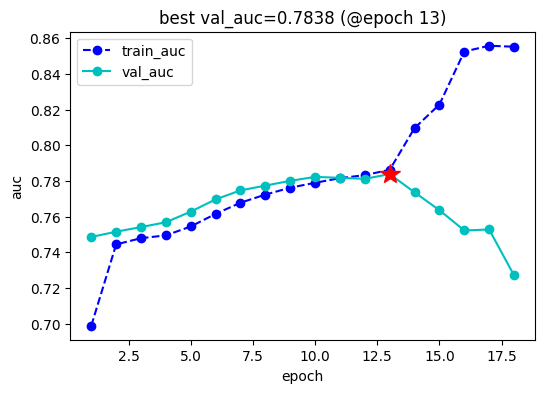

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



In [15]:
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=5,
    monitor='val_auc',
    mode='max',
    plot=True,
    cpu=True
)

### 4，评估模型

In [16]:
model.evaluate(dl_test)

100%|████████████████████████████████| 98/98 [00:04<00:00, 22.22it/s, val_auc=0.781, val_loss=0.466]


{'val_loss': 0.46555993021750935, 'val_auc': 0.7811386585235596}

### 5，使用模型

In [18]:
from sklearn.metrics import roc_auc_score
model.eval()
dl_test = model.accelerator.prepare(dl_test)
with torch.no_grad():
    result = torch.cat([model.forward(t[0]) for t in dl_test])

preds = F.sigmoid(result)
labels = torch.cat([x[-1] for x in dl_test])

val_auc = roc_auc_score(labels.numpy(),preds.numpy())
print(val_auc)


0.7811383534406475


### 6，保存模型

模型最佳权重已经保存在 model.fit(ckpt_path) 传入的参数中了。

In [19]:
net_clone = create_net()
net_clone.load_state_dict(torch.load(model.ckpt_path))

<All keys matched successfully>

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)